In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import h5py

In [48]:
# want to plot average shot after removing n eigneimages
def reshape_unmasked_values_to_shots(shots,mask):
    # this takes vectors of unmasked values, and reshaped this into their masked forms
    # mask is 2D, shots are 1D
    assert(shots.shape[-1]==np.sum(mask) )
    flat_mask = mask.flatten()
    reshaped_shots = np.zeros( (shots.shape[0],mask.size), dtype=shots.dtype)
    
    reshaped_shots[:, flat_mask==1] = shots
    
    return reshaped_shots.reshape((shots.shape[0],mask.shape[0],mask.shape[1]))

def ave_shot_series(sample,run_num,
                   file_num):
    f = h5py.File('/reg/d/psdm/cxi/cxilr6716/scratch/norm_shots/cali_gai_filtered/%s/run%d_normShots_%d.h5'%(sample, run_num, file_num),
                  'r')
    f2 = h5py.File('/reg/d/psdm/cxi/cxilr6716/scratch/pca_denoise/cali_gai_filtered2/%s/run%d_PCA-denoise_%d.h5'%(sample, run_num, file_num),
                   'r')
    
    f_mask =h5py.File('/reg/d/psdm/cxi/cxilr6716/scratch/combined_tables/cali_gai/run%d.tbl'%run_num,'r')
    
    mask = np.array(f_mask['polar_mask_binned'].value==f_mask['polar_mask_binned'].value.max(), dtype = int)[:36]
    all_ave_shots=[]
    for qidx in range(len(f.keys())):        
        Train = f['q%d/train_shots'%qidx].value

        components = f2['q%d/pca_components'%qidx].value
        _m = Train.astype(np.float64).mean(0)
        new_Train = (Train.astype(np.float64)-_m).dot(components.T)

        partial_mask=mask[qidx][None,:]
        ave_shots=[reshape_unmasked_values_to_shots(Train-Train.mean(0)[None,:]
                                                , partial_mask).mean(0)[0]]
        for nn in range(1,components.shape[0]):
        #denoise
            Train_noise = new_Train[:,:nn].dot(components[:nn])
            denoise_Train= reshape_unmasked_values_to_shots(Train-Train_noise-Train.mean(0)[None,:]
                                                , partial_mask).mean(0)[0]
            ave_shots.append(denoise_Train)
        ave_shots = np.array(ave_shots)
        all_ave_shots.append(ave_shots)
    all_ave_shots=np.array(all_ave_shots)
    return all_ave_shots

In [181]:
ls /reg/d/psdm/cxi/cxilr6716/scratch/norm_shots/cali_gai_filtered/ALF_pro/

run120_normShots_0.h5  run120_normShots_1.h5


In [258]:
ave_shots = ave_shot_series('ALF_buf', 118, 0)
# ave_shots1 = ave_shot_series('ALF_buf', 118, 1)
ave_shots_pro = ave_shot_series('ALF_pro', 120, 0)


In [50]:
ave_shots.shape

(36, 20, 326)

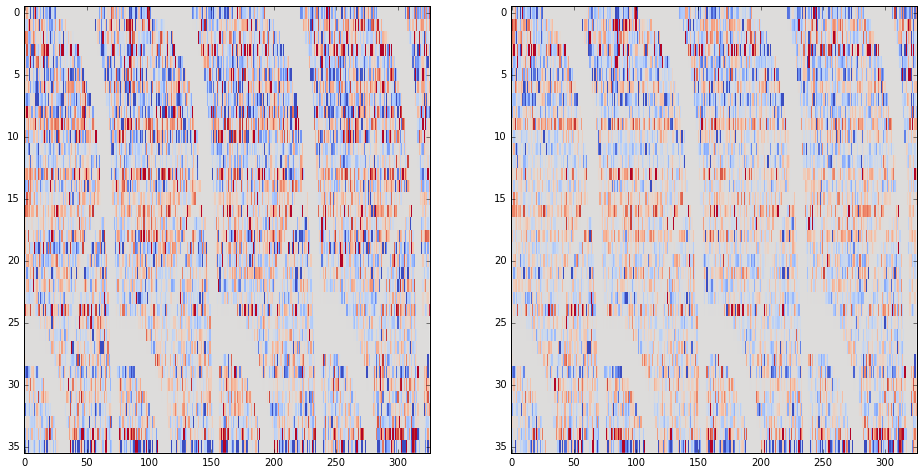

In [268]:
plt.figure(figsize=[16,8])
plt.subplot(121)
plt.imshow(ave_shots_pro[:,0], aspect='auto', cmap='coolwarm',
          vmin=-0.3e-11,vmax=0.3e-11, interpolation='none')


plt.subplot(122)
plt.imshow(ave_shots_pro[:,19], aspect='auto', cmap='coolwarm',
          vmin=-0.3e-11,vmax=0.3e-11, interpolation='none')
# plt.colorbar()

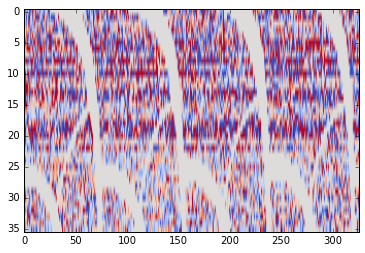

In [242]:
plt.imshow(ave_shots[:,0]-ave_shots[:,1], aspect='auto', cmap='coolwarm',
          vmin=-0.1e-11,vmax=0.1e-11)
# plt.colorbar()

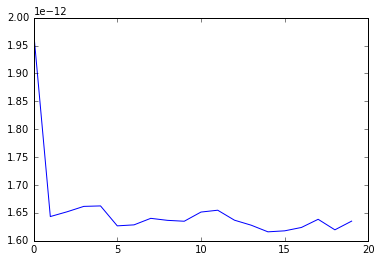

In [123]:
# plt.plot(ave_shots.std(-1)[0])
plt.plot(ave_shots.std(-1)[3,:])

In [260]:
stdev = ave_shots_pro.std(-1)
stdev /= stdev.max(-1)[:,None]

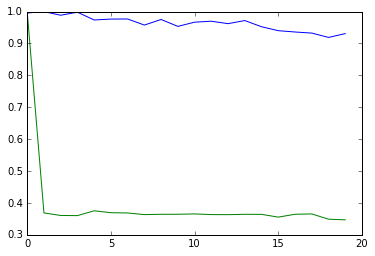

In [280]:
for dd in [1,8]:
    plt.plot(stdev[dd])

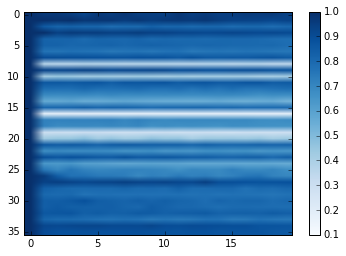

In [281]:
plt.imshow(stdev, aspect='auto', cmap='Blues',
          vmin=0.1)
plt.colorbar()

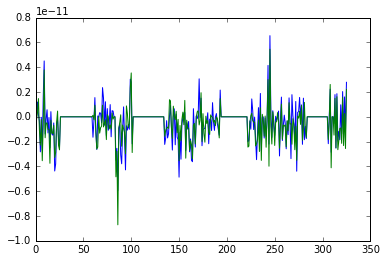

In [284]:
x=ave_shots_pro[:,0]
y=ave_shots_pro[:,1]
diff=x-y

qidx=0
# plt.plot(diff[qidx])
plt.plot(x[qidx])
# plt.plot(y[qidx])
plt.plot(ave_shots_pro[:,19][qidx])
# plt.plot(ave_shots1[:,19][qidx])

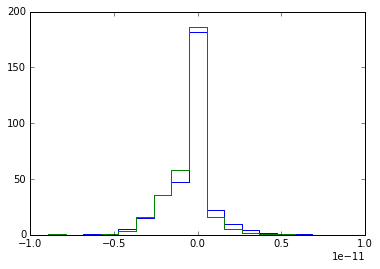

In [287]:
qidx=0
bins = np.linspace(-1e-11,1e-11,20)
hist1 = np.histogram(ave_shots_pro[qidx,0], bins)
hist2 = np.histogram(ave_shots_pro[qidx,19],bins)
# hist3 = np.histogram(ave_shots1[qidx,1],bins)
plt.step(hist1[1][1:], hist1[0])
plt.step(hist2[1][1:], hist2[0])
# plt.step(hist3[1][1:], hist3[0])